In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from uti.newLeaner_05b import *

In [3]:
train_ds,valid_ds = get_dataset(*get_data())
data = Databunch(*get_dl(train_ds,valid_ds,bs=64),c=10)
loss_func = F.cross_entropy

/home/jupyter/.fastai/data/mnist.pkl.gz


In [9]:
#export
class Recorder(Callback):
    _order = 1
    def begin_fit(self):
        self.losses, self.lrs = [], []
    
    def after_loss(self):
        if self.learn.in_train:
            self.losses.append(self.learn.loss)
            self.lrs.append(self.learn.opt.param_groups[0]['lr'])
            
    def plot_lr(self):
        plt.plot(self.lrs)
        
    def plot_loss(self):
        plt.plot(self.losses)

In [10]:
learn = NewLearner(*get_model(data),loss_func,data,cbs=[Recorder(),Accuracy()])

In [11]:
learn.fit(2)

Train: 0.31340810656547546, 0.9035599827766418
Valid: 0.22460515797138214, 0.9297999739646912
 
Train: 0.14118525385856628, 0.9577800035476685
Valid: 0.28539061546325684, 0.9168999791145325
 


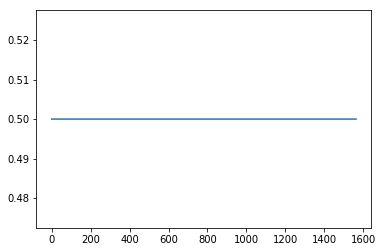

In [13]:
learn.cbs[2].plot_lr()

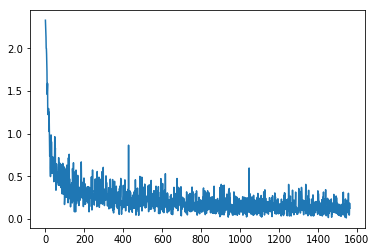

In [14]:
learn.cbs[2].plot_loss()

Recorder works fine, now we just need to re implement LR_find using new Leaner

In [18]:
#export
class LR_find(Callback):
    def begin_fit(self,start=1e-8,end=10.,beta=0.98):
        self.start, self.end, self.beta = start, end, beta
        self.current_lr = start
        self.ratio = (end / start) ** (1 / (len(self.learn.data.train_dl)-1))
        self.lr = []
        self.losses = []
        self.best_loss = 0.
        self.avg_loss = 0.
        self.smooth_loss = 0.
        self.batch_num = 0
        
    def begin_batch(self):
        self.batch_num += 1
        self.learn.opt.param_groups[0]['lr'] = self.current_lr
        
    
    def after_loss(self):
        self.loss = self.learn.loss
        self.avg_loss = self.avg_loss * self.beta + self.loss.data * (1 - self.beta)
        self.smooth_loss = self.avg_loss / (1 - self.beta ** self.batch_num) #debias
        if self.batch_num > 1 and self.smooth_loss > 4 * self.best_loss:
            raise CancelTrainException()
        if self.batch_num == 1 or self.best_loss > self.smooth_loss:
            self.best_loss = self.smooth_loss
            self.best_lr = self.current_lr
        self.losses.append(self.smooth_loss)
        self.lr.append(math.log10(self.current_lr))
        self.current_lr *= self.ratio
        
    
    def begin_validate(self):
        raise CancelTrainException()

In [19]:
lr_find = LR_find()
learn = NewLearner(*get_model(data),loss_func,data,cbs=[lr_find])

In [20]:
learn.fit(1)

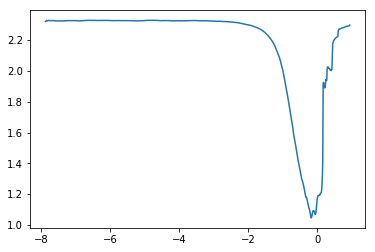

In [22]:
plt.plot(lr_find.lr[10:-5],lr_find.losses[10:-5])